In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from experiment_0 import exp000
from experiment_1 import exp001
from experiment_2 import exp002
from experiment_5 import exp005
from experiment_6 import exp006,exp007

# 1. piece-wise differentiable dynamics 

When we include many modes in the dynamics, the derivative becomes discontinuous. This can be seen analyzing WW simulations, or directly derived from our Delayed Differential Equations 

c:\Users\cbara\Documents\python_projects\non_markovian_qubit_swap\experiment_0.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


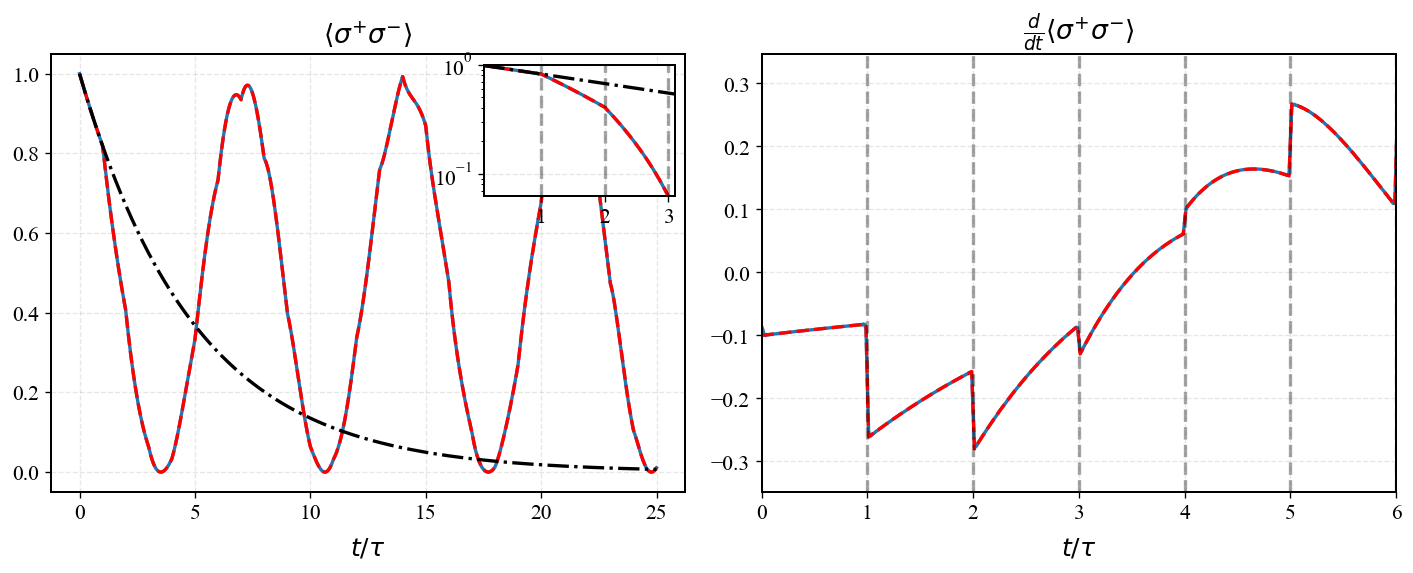

In [2]:
exp000(Delta=50,gamma=0.1,periods_derivative=6,n_steps=2001,n_modes=100)

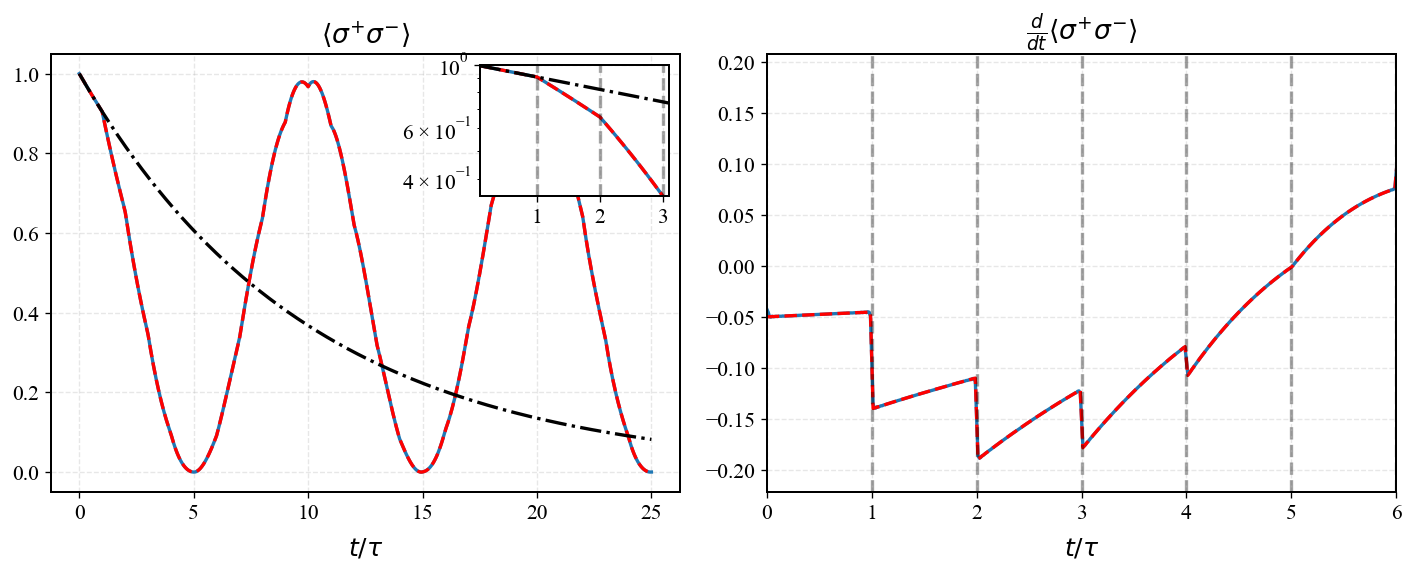

In [3]:
exp000(Delta=50,gamma=0.05,periods_derivative=6,n_steps=2001,n_modes=100)

# 2. Delayed Differential Equations match cavities in high energies 

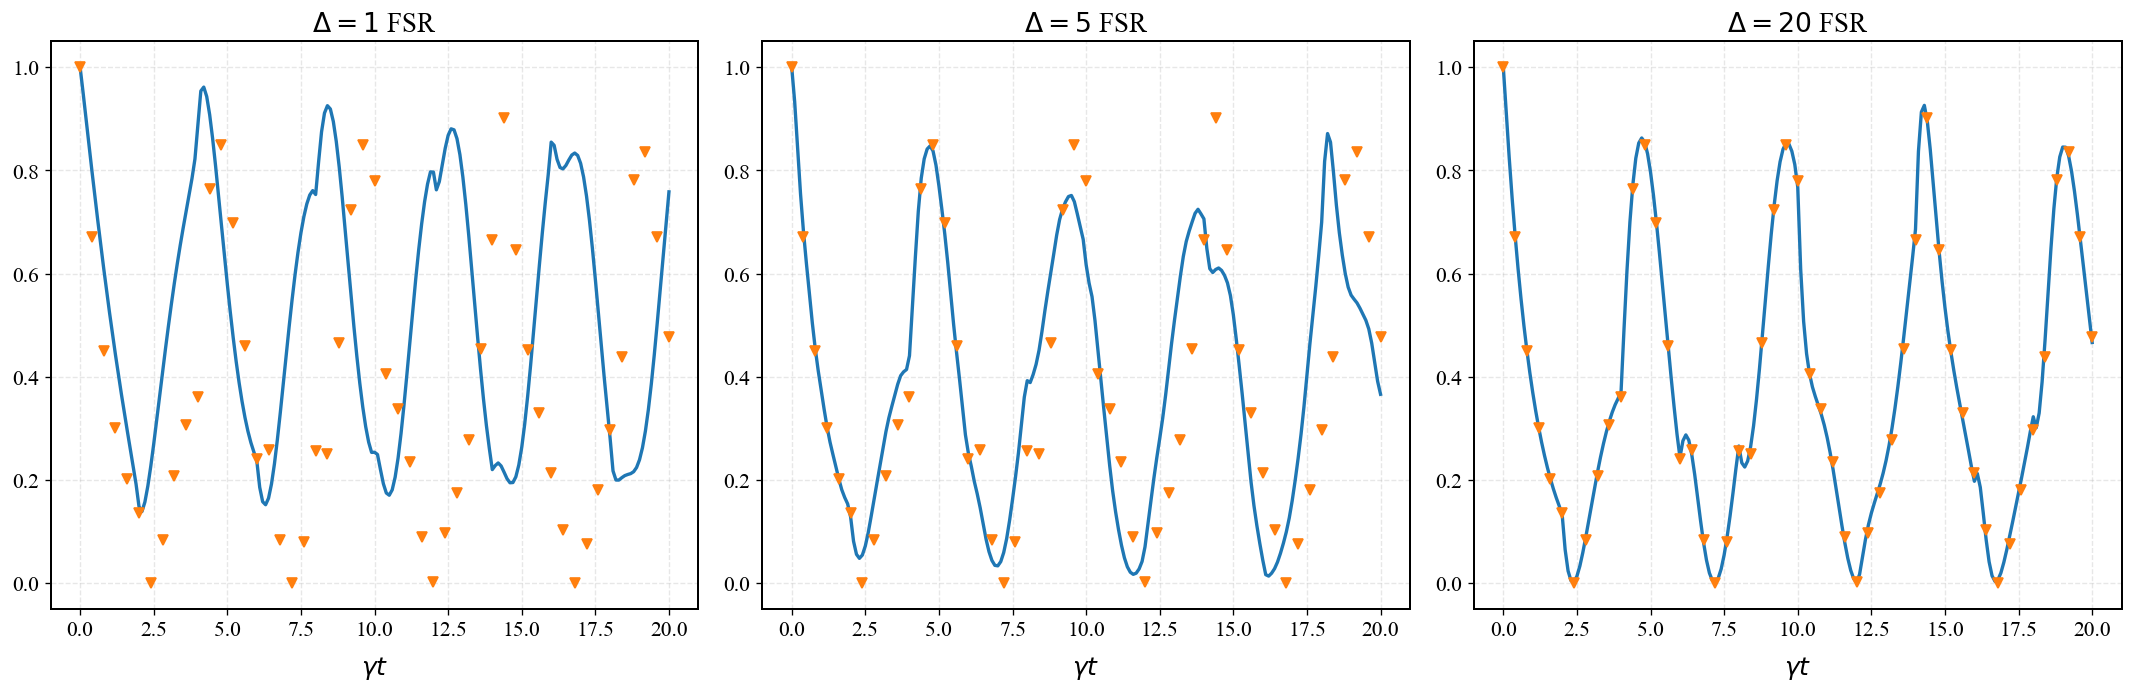

In [2]:
exp001(t_max=20,gamma=1,Delta_list=[1,5,20])

# 3. Lamb shift and gamma corrections improve the oscillations 

lamb shift: 1.1482702347487654 F.S.R.
correction to gamma: 0.04021352233707509
2.234313382768428


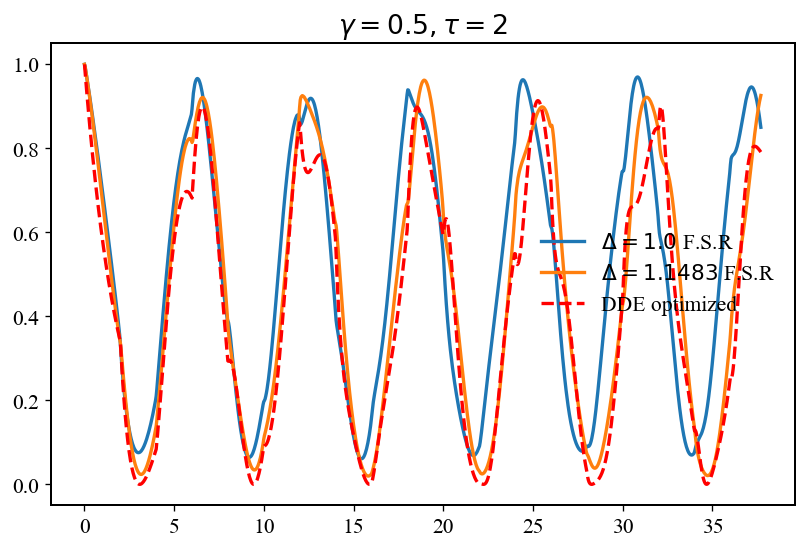

In [7]:
exp005(gamma=0.5)

## 3.1 parameters corrections vs free space coupling $\gamma$ 

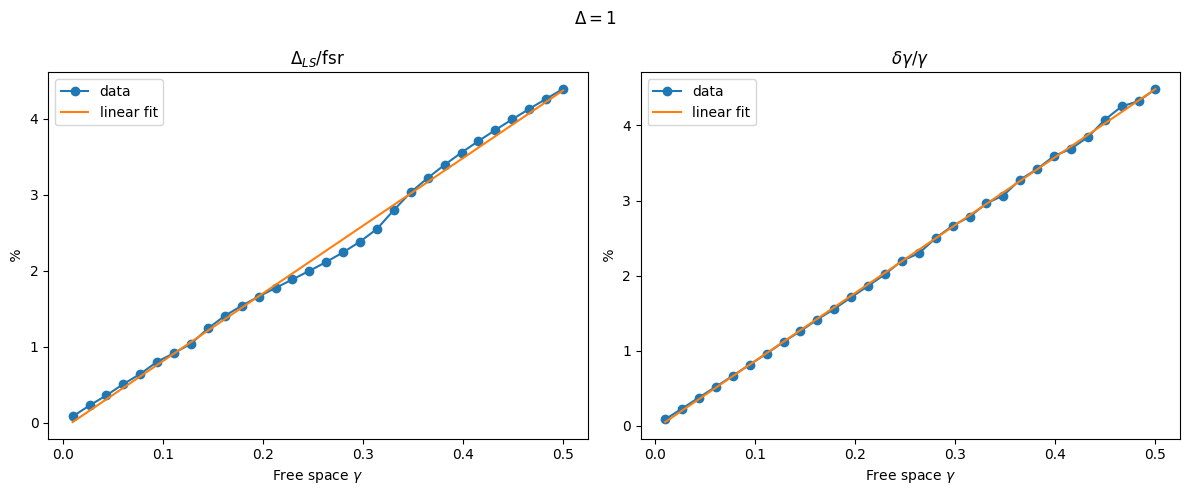

In [3]:
lamb_1,gamma_s_1=exp006(Delta=1,n_modes=100,n_steps=1201)

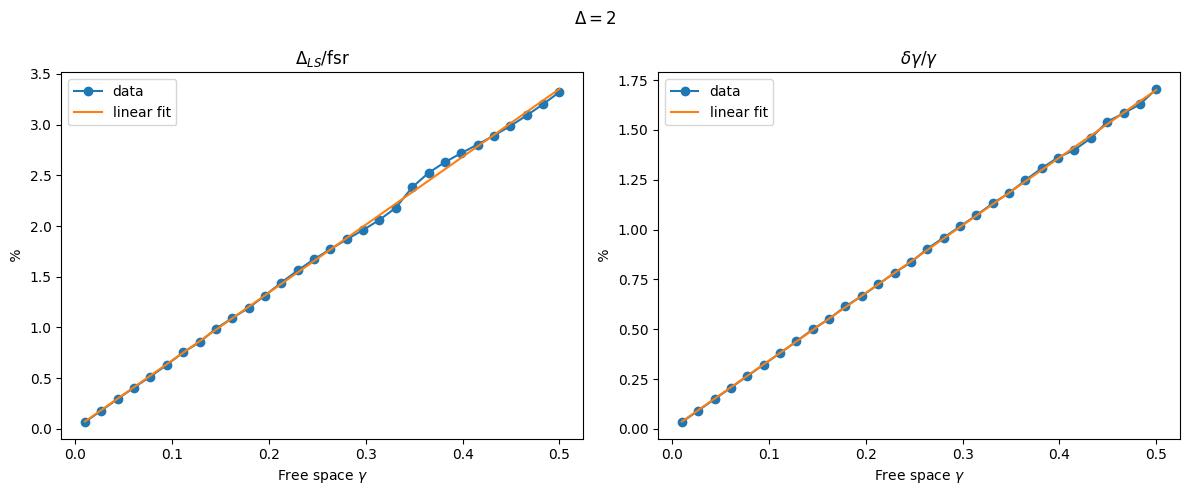

In [4]:
lamb_2,gamma_s_2=exp006(Delta=2,n_modes=100,n_steps=1201)

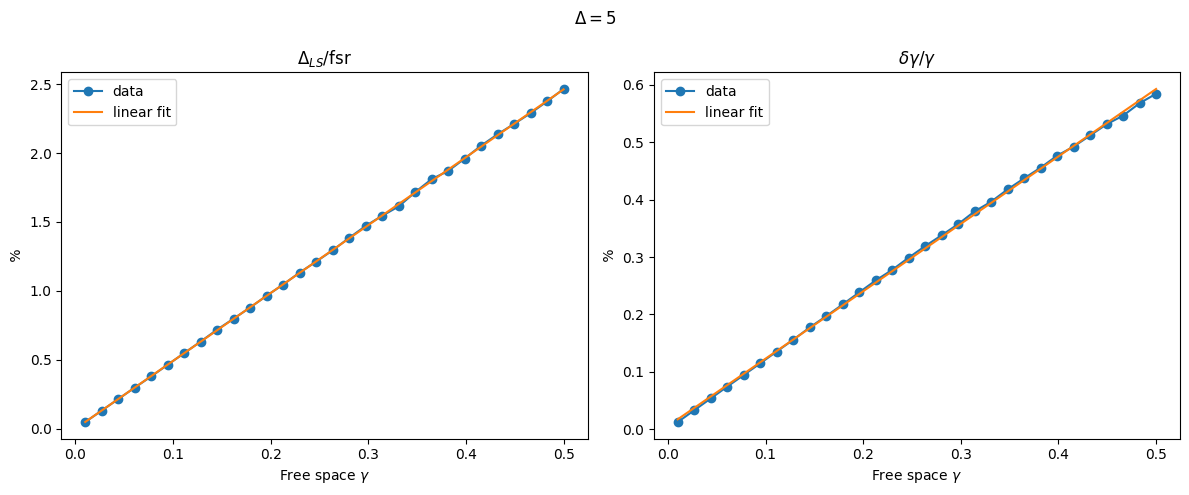

In [5]:
lamb_3,gamma_s_3=exp006(Delta=5,n_modes=100,n_steps=1201)

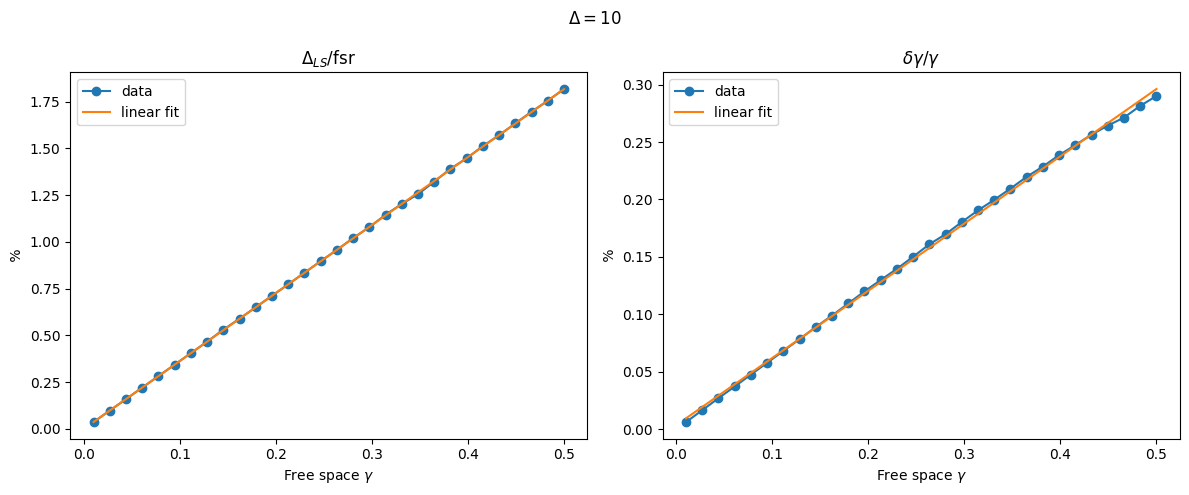

In [6]:
lamb_4,gamma_s_4=exp006(Delta=10,n_modes=100,n_steps=1201)

## 3.2 parameter  corrections vs frequency of the qubit $\Delta$ 

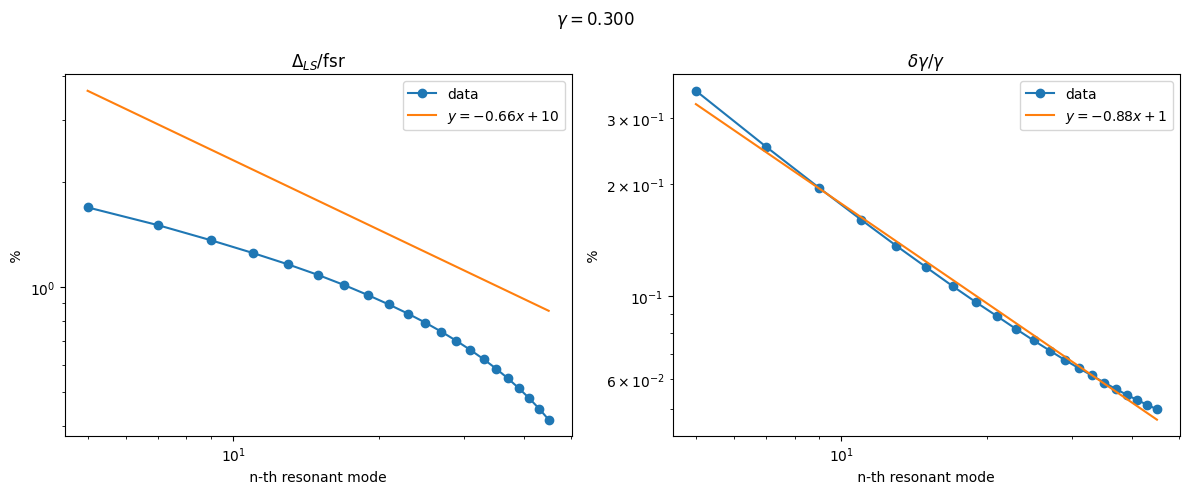

In [2]:
_,_=exp007()

# 4. Extra: Error VS frequency of the qubit $\Delta$ 

In [ ]:
from aux_funs import DDE_analytical,run_ww_simulation
from typing import Optional

def exp003(t_max: Optional[float] = None , gamma :float = 0.1, Delta_list: list = [5,20,50], n_modes_list: list =[20,40,60],L:float = 1, c: float = 1, n_steps: int = 201,n_modes=20):
	tau =2*L/c
	if t_max is None:
		t_max = 25*tau 

	fig,axs = plt.subplots(1,len(Delta_list),figsize=(8*len(Delta_list),5))
	
	for i,Delta in enumerate(Delta_list):
		error_nmodes=[]
		phi = 2*np.pi*Delta
		for n_modes in n_modes_list:
			t_ww,e_ww = run_ww_simulation(t_max=t_max,gamma=gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps)
			e_dde = np.abs(DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t_ww))**2
			error_nmodes.append(np.sum(np.abs(e_ww.T-e_dde))/np.sum(np.abs(e_ww)))

		axs[i].plot(n_modes_list,error_nmodes,'-o')
		axs[i].set_xlabel('number of modes')
		axs[i].set_ylabel('diference between ww and dde')
		axs[i].grid()
		axs[i].set_title(rf"$ \Delta = {Delta:.1f}$ F.S.R. ")
	fig.tight_layout()
	plt.show()



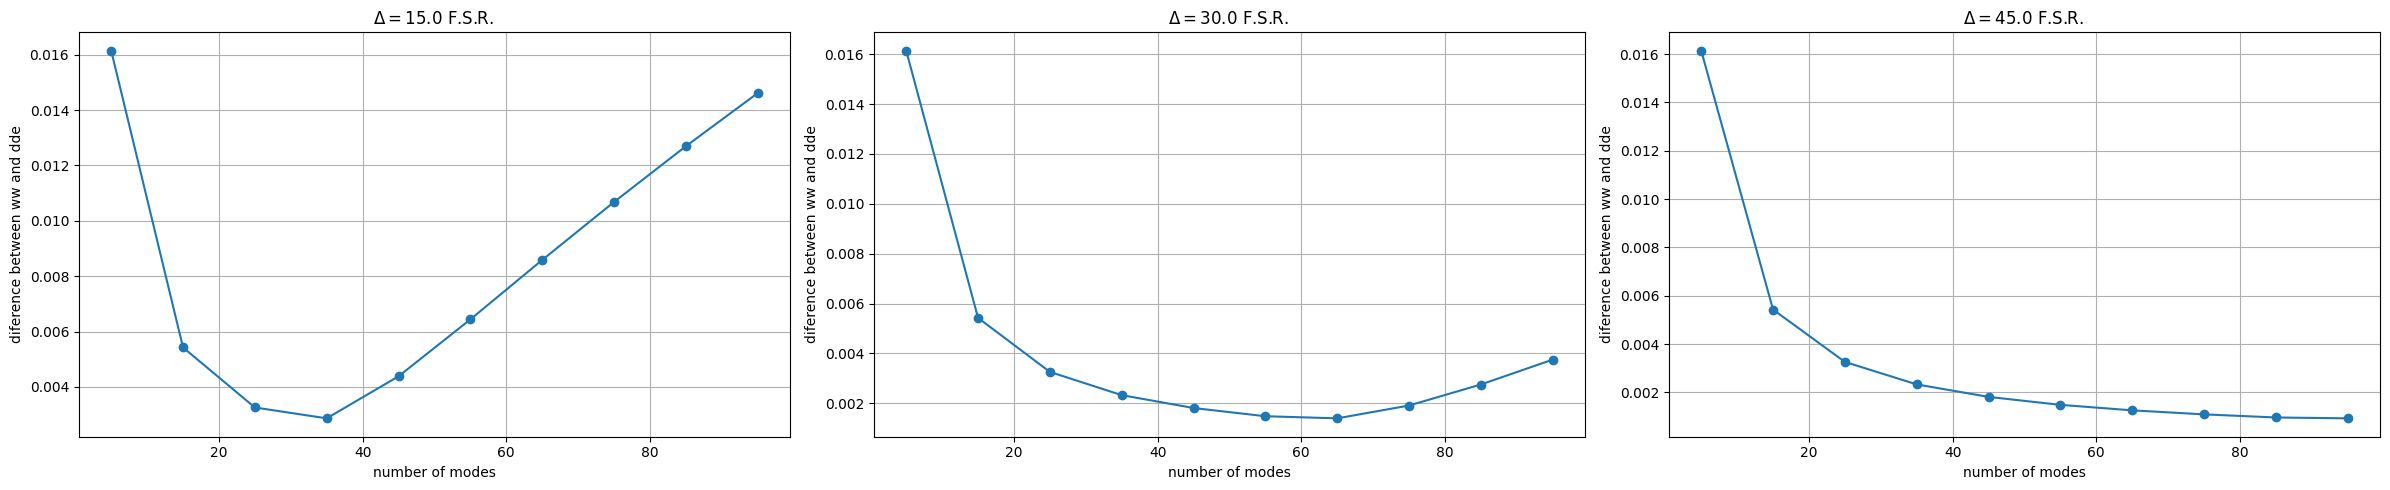

In [ ]:
exp003(Delta_list=[15,30,45],n_modes_list=list(range(5,96,10)))

# 5. Extra: analytical solution of the DDE

The result I dont want to prove (although I can) is 

\begin{equation}
\partial_{t}f(t) = -\gamma \sum_{n}e^{n\alpha \tau}f(t-n\tau)\Theta(t-n\tau) \longrightarrow f(t) = \Theta(t) + \sum_{n=1}^{\infty} e^{n\alpha \tau} \left[ \sum_{m=1}^{n} \binom{n-1}{m-1} (-\gamma)^{m} \frac{(t-n\tau)^{m}}{m!} \right] \Theta(t-n\tau)
\end{equation}

Now I show how this is related to the DDE for two qubits in a ring. The set of equations describing this system is: 

$$ \partial_{t} \hat{c}_{1}(t) = -\left(i\omega_{e} +\frac{\gamma}{2} \right) \hat{c}_{1}(t) - \gamma \sum_{m=1}^{\infty}  \hat{c}_{1}(t-(2n)\tau) -\gamma \sum_{n=1}^{\infty}\hat{c}_{2}(t-(2n-1)\tau) $$

$$ \partial_{t} \hat{c}_{2}(t) = -\left( i \omega_{e} + \frac{\gamma}{2} \right)\hat{c}_{2}(t) - \gamma \sum_{m=1}^{\infty}  \hat{c}_{2}(t-(2n)\tau) -\gamma \sum_{n=1}^{\infty}\hat{c}_{1}(t-(2n-1)\tau) $$

also, the analytical solution for bosons requires 

$$ \hat{c}_{1}(t) = J_{11}(t)\hat{c}_{1}(0) + J_{12}(t)\hat{c}_{2}(0) $$
$$ \hat{c}_{2}(t) = J_{21}(t)\hat{c}_{1}(0) + J_{22}(t)\hat{c}_{2}(0) $$

which leads to equations for functions, rather than operators. We now have two identical systems of coupled differential equations. 
\begin{cases}
\partial_{t}J_{11}(t) = -\left(i\omega_{e} +\frac{\gamma}{2} \right)J_{11}(t) - \gamma \sum_{m=1}^{\infty}  J_{11}(t-(2n)\tau) - \gamma \sum_{n=1}^{\infty}J_{21}(t-(2n-1)\tau) \\
\partial_{t}J_{21}(t) = -\left(i\omega_{e} +\frac{\gamma}{2} \right)J_{21}(t) - \gamma \sum_{m=1}^{\infty}  J_{21}(t-(2n)\tau) - \gamma \sum_{n=1}^{\infty}J_{11}(t-(2n-1)\tau) 
\end{cases}

Is the system that we need to solve. by defining $	\tilde{J}_{\pm}(t) = J_{11}(t) \pm J_{21}(t) $ we find that equations decouple into 

$$ \partial_{t} \tilde{J}_{\pm}(t) = -\left(i\omega_{e} +\frac{\gamma}{2} \right)\tilde{J}_{\pm}(t) - \gamma \sum_{m=1}^{\infty}  \tilde{J}_{\pm}(t-(2n)\tau) \mp \gamma \sum_{n=1}^{\infty}\tilde{J}_{\pm}(t-(2n-1)\tau) $$



The equation for $ \tilde{J}_{+}(t) $ is directly the equation for a qubit in a cavity, since we group up the even and odd terms and yield

$$ \partial_{t} \tilde{J}_{+}(t) = -\left(i\omega_{e} +\frac{\gamma}{2} \right)\tilde{J}_{+}(t) -\gamma \sum_{n}J_{+}(t-n\tau)$$
doing a rotating frame $ \tilde{J}(t) \to J(t)e^{-\left(i\omega_{e} +\frac{\gamma}{2} \right)t} $ we get 

$$ \partial_{t} J_{+}(t) =  -\gamma \sum_{n}e^{n\left(i\omega_{e} + \frac{\gamma}{2} \right)\tau}J_{+}(t-n\tau) $$
Which is the equation I was solving before. 


The equation for $\tilde{J}_{-}(t) $ has a small twist. we can do 

\begin{equation}
\partial_{t}\tilde{J}_{-}(t) = -\left(i\omega_{e} +\frac{\gamma}{2} \right)\tilde{J}_{-}(t) - \gamma \sum_{m=1}^{\infty} e^{i(2n)\pi} \tilde{J}_{-}(t-(2n)\tau) - \gamma \sum_{n=1}^{\infty}e^{i(2n-1)\pi}\tilde{J}_{\pm}(t-(2n-1)\tau) 
\end{equation}
which is 
\begin{equation}
\partial_{t}\tilde{J}_{-}(t) = -\left(i\omega_{e} +\frac{\gamma}{2} \right)\tilde{J}_{-}(t) - \gamma \sum_{m=1}^{\infty} e^{in\pi} \tilde{J}_{-}(t-n\tau) 
\end{equation}

and, after going to the rotating frame, you get 

\begin{equation}
\partial_{t}J_{-}(t) =  - \gamma \sum_{m=1}^{\infty} e^{n\left[ i(\omega_{e}+\pi) + \frac{\gamma}{2} \right]\tau} \tilde{J}_{-}(t-n\tau) 
\end{equation}

which again can be solved. All of this is just to say that $J_{-}(t)$ is not quite the analytical solution to the cavity, the rotating frame has an extra $\pi$ that you need to be careful with.

finally, the general solution is given by

\begin{cases}
\hat{c}_{1}(t) = \frac{J_{+}(t)+J_{-}(t)}{2} \hat{c}_{1}(0) + \frac{J_{+}(t)-J_{-}(t)}{2} \hat{c}_{2}(0) \\
\hat{c}_{2}(t) = \frac{J_{+}(t)-J_{-}(t)}{2} \hat{c}_{1}(0) + \frac{J_{+}(t)+J_{-}(t)}{2} \hat{c}_{2}(0)
\end{cases}